# CL - Dynamic architectures

A small experiment with a convolutional network on MNIST and FashionMNIST datasets. The goal is to train the network on MNIST and then on FashionMNIST. The network should be able to learn both datasets without forgetting the first one.

In this notebook, we try a method called "Dynamic architectures". For sake of simplicity, the network will have 2 output layers, one for MNIST and one for FashionMNIST. The code for a real dynamical architecture is much more complex.

In [1]:
import torch
from torch import nn, optim
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, log_loss

In [2]:
subsample = 10_000
batch_size = 128
mnist_epochs = 5
fashion_epochs = 5
mnist = True
fashion = True

In [3]:
# import MNIST
train_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.MNIST(
    root="./mnist",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
mnist_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
mnist_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [4]:
# import FashionMNIST
train_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=True,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)
test_data = torchvision.datasets.FashionMNIST(
    root="./fashion",
    train=False,
    transform=torchvision.transforms.ToTensor(),
    download=True,
)

print(train_data.data.shape)

# sample subsample images
# train_data = torch.utils.data.Subset(train_data, range(subsample))
# test_data = torch.utils.data.Subset(test_data, range(subsample))
fashion_train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
fashion_test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

torch.Size([60000, 28, 28])


In [5]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.max_pool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(12 * 12 * 32, 128)
        self.fc2 = nn.Linear(128, 10)
        self.fc3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(0.5)

    def forward(self, x):
        # convolutions
        x = self.conv1(x)
        x = self.max_pool(self.conv2(x))
        # classifier - MNIST
        x = x.view(-1, 12 * 12 * 32)
        x = torch.relu(self.fc1(x))
        x = self.drop(x)
        return torch.softmax(self.fc2(x), dim=1), torch.softmax(self.fc3(x), dim=1)

In [6]:
def evaluate_mnist(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(mnist_test_dataloader):
        output, _ = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("MNIST - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [7]:
def evaluate_fashion(verbose=1):
    cnn.eval()
    # evaluate on test set and calculate f1 score
    y_pred = torch.empty(0, dtype=torch.long)
    y_test = torch.empty(0, dtype=torch.long)
    for _, (X_batch, y_batch) in enumerate(fashion_test_dataloader):
        _, output = cnn(X_batch)
        y_pred = torch.cat((y_pred, torch.argmax(output, dim=1)))
        y_test = torch.cat((y_test, y_batch))
    if verbose:
        print("Fashion - F1 score", f1_score(y_test, y_pred, average="macro"))
    return f1_score(y_test, y_pred, average="macro")

In [8]:
cnn = CNN()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=1e-3)

mnist_scores = []
fashion_scores = []

# MNIST
if mnist:
    print("--- MNIST ---")
    cnn.train()
    for epoch in range(mnist_epochs):
        for _, (X_batch, y_batch) in enumerate(mnist_train_dataloader):
            optimizer.zero_grad()
            output, _ = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_fashion()
    evaluate_mnist()

--- MNIST ---
Epoch 0 - loss 1.5311737060546875
Epoch 1 - loss 1.4860140085220337
Epoch 2 - loss 1.49577796459198
Epoch 3 - loss 1.5007638931274414
Epoch 4 - loss 1.4911490678787231
--- Scores ---
Fashion - F1 score 0.07293097503782722
MNIST - F1 score 0.9753703116357784


In [9]:
# FashionMNIST
if fashion:
    print("--- FashionMNIST ---")

    cnn.train()
    for epoch in range(fashion_epochs):
        for _, (X_batch, y_batch) in enumerate(fashion_train_dataloader):
            optimizer.zero_grad()
            _, output = cnn(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch} - loss", loss.item())
        mnist_scores.append(evaluate_mnist(verbose=0))
        fashion_scores.append(evaluate_fashion(verbose=0))

    print("--- Scores ---")
    evaluate_mnist()
    evaluate_fashion()

--- FashionMNIST ---
Epoch 0 - loss 1.7043066024780273
Epoch 1 - loss 1.6495434045791626
Epoch 2 - loss 1.5583786964416504
Epoch 3 - loss 1.6338475942611694
Epoch 4 - loss 1.5488766431808472
--- Scores ---
MNIST - F1 score 0.8513060108282048
Fashion - F1 score 0.8819560440436046


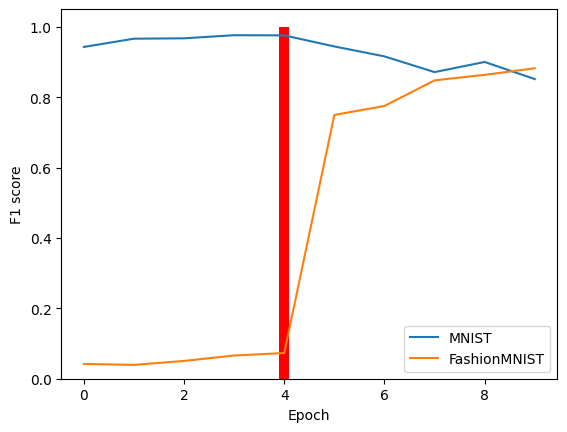

In [12]:
plt.figure()
plt.plot(mnist_scores, label="MNIST")
plt.plot(fashion_scores, label="FashionMNIST")
plt.bar(mnist_epochs - 1, height=1, width=0.2, color="r")
plt.xlabel("Epoch")
plt.ylabel("F1 score")
plt.legend()
plt.savefig("figures/cnn_dynamic_architecture.png")
plt.show()